# Multi-step forecasting: recursive approach

In the previous notebooks, we predicted the hourly pollutant concentration for the next 24 hours utilizing a direct approach.

Here, we will carry out multi-step forecasting using a recursive approach.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# Same function we saw in section 2.

def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor", "RH"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]
    
    ######## NEW #########
    # Add missing timestamps (easier for the demo)
    data = data.asfreq("1H")

    # Fill in missing data.
    data = data.fillna(method="ffill")
    ######################
    
    return data

In [3]:
# Load data.

data = load_data()

data.head()

,CO_sensor,RH
Date_Time,,
2004-04-01 00:00:00,1143.0,61.6
2004-04-01 01:00:00,1044.0,63.9
2004-04-01 02:00:00,1034.0,67.2
2004-04-01 03:00:00,956.0,73.1
2004-04-01 04:00:00,909.0,66.6


# Feature engineering steps

The same pipeline from the previous notebook.

In [4]:
# Datetime features
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [5]:
# Lag features.

lagf = LagFeatures(
    variables=["CO_sensor"],  # the input variables
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [6]:
# Window features

winf = WindowFeatures(
    variables=["CO_sensor"],  # the input variables
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [7]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [8]:
# Drop missing data
imputer = DropMissingData()

In [9]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["CO_sensor", "RH"])

# Feature engineering pipeline

In [10]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

# Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need data about the pollutant information at least 24 hours before the first forecasting point in the test set to create the input features.

In [11]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"][["CO_sensor", "RH"]]
y_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)][[
    "CO_sensor", "RH",
]]

In [12]:
y_train.head()

,CO_sensor,RH
Date_Time,,
2004-04-01 00:00:00,1143.0,61.6
2004-04-01 01:00:00,1044.0,63.9
2004-04-01 02:00:00,1034.0,67.2
2004-04-01 03:00:00,956.0,73.1
2004-04-01 04:00:00,909.0,66.6


# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [13]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_sensor_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,
2004-04-02 00:00:00,4,14,4,2,0,0,1203.0,1143.0,1193.666667,0.866025,-0.5,0.000000,1.000000
2004-04-02 01:00:00,4,14,4,2,1,0,1139.0,1044.0,1176.000000,0.866025,-0.5,0.269797,0.962917
2004-04-02 02:00:00,4,14,4,2,2,0,1072.0,1034.0,1138.000000,0.866025,-0.5,0.519584,0.854419
2004-04-02 03:00:00,4,14,4,2,3,0,954.0,956.0,1055.000000,0.866025,-0.5,0.730836,0.682553
2004-04-02 04:00:00,4,14,4,2,4,0,951.0,909.0,992.333333,0.866025,-0.5,0.887885,0.460065


In [14]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(8088, 2)
(8064, 2)


In [15]:
# Lasso regression

# We need a prediction for CO concentration
# and a prediction for RH.

lasso = MultiOutputRegressor(Lasso(random_state=0))

# Train the model

lasso.fit(X_train_t, y_train_t)

MultiOutputRegressor(estimator=Lasso(random_state=0))

# Forecasting 24 hours forward - step by step

First, we will obtain a forecast for the first 24 hours in the test set.

In [16]:
# The first hour of forecast.
forecast_point = pd.Timestamp("2005-03-04")

# The forecasting horizon (24 hs ahead)
forecast_end = forecast_point + pd.offsets.Hour(23)

forecast_point, forecast_end

(Timestamp('2005-03-04 00:00:00'), Timestamp('2005-03-04 23:00:00'))

In [17]:
# The timestamps at which we want to predict
# CO concentration.

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="1H",
)

index

DatetimeIndex(['2005-03-04 00:00:00', '2005-03-04 01:00:00',
               '2005-03-04 02:00:00', '2005-03-04 03:00:00',
               '2005-03-04 04:00:00', '2005-03-04 05:00:00',
               '2005-03-04 06:00:00', '2005-03-04 07:00:00',
               '2005-03-04 08:00:00', '2005-03-04 09:00:00',
               '2005-03-04 10:00:00', '2005-03-04 11:00:00',
               '2005-03-04 12:00:00', '2005-03-04 13:00:00',
               '2005-03-04 14:00:00', '2005-03-04 15:00:00',
               '2005-03-04 16:00:00', '2005-03-04 17:00:00',
               '2005-03-04 18:00:00', '2005-03-04 19:00:00',
               '2005-03-04 20:00:00', '2005-03-04 21:00:00',
               '2005-03-04 22:00:00', '2005-03-04 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [18]:
# As expected, we have 24 timestamps in total,
# corresponding to each one of the hours ahead that
# we want to forecast, respect to the forecasting
# start point.

len(index)

24

In [19]:
# The forecasting horizon - dataframe to collect predictions

f_horizon = pd.DataFrame(columns=["CO_sensor", "RH"], index=index)

f_horizon

,CO_sensor,RH
2005-03-04 00:00:00,NaN,NaN
2005-03-04 01:00:00,NaN,NaN
2005-03-04 02:00:00,NaN,NaN
2005-03-04 03:00:00,NaN,NaN
2005-03-04 04:00:00,NaN,NaN
2005-03-04 05:00:00,NaN,NaN
2005-03-04 06:00:00,NaN,NaN
2005-03-04 07:00:00,NaN,NaN
2005-03-04 08:00:00,NaN,NaN
2005-03-04 09:00:00,NaN,NaN


## Forecast 1 hour forward

We will create a dataframe that contains the necessary data to make the first point of forecast.

In [20]:
# 24 hs before the first forecasting point

start_point = forecast_point - pd.offsets.Hour(24)

start_point

Timestamp('2005-03-03 00:00:00')

In [21]:
# We create input data to obtain the first prediction value.

input_data = X_test[(X_test.index >= start_point) & (X_test.index < forecast_point)]

input_data.loc[forecast_point] = np.nan

input_data

/var/folders/td/8cdrl7y9071dt4z0j5965_pw0000gn/T/ipykernel_1300/1524750638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = np.nan


,CO_sensor,RH
Date_Time,,
2005-03-03 00:00:00,1047.0,41.7
2005-03-03 01:00:00,1030.0,43.3
2005-03-03 02:00:00,986.0,45.9
2005-03-03 03:00:00,992.0,49.7
2005-03-03 04:00:00,1076.0,56.3
2005-03-03 05:00:00,1104.0,67.9
2005-03-03 06:00:00,1160.0,74.1
2005-03-03 07:00:00,1217.0,75.6
2005-03-03 08:00:00,1457.0,72.4


In [22]:
len(input_data)

25

In [23]:
# test transformation

pipe.transform(input_data)

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_sensor_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,
2005-03-04,3,9,4,4,0,0,1179.0,1047.0,1223.333333,1.0,6.123234e-17,0.0,1.0


In [24]:
# Let's obtain the first prediction.

pred = lasso.predict(pipe.transform(input_data))

pred

array([[1112.60467101,   57.61012276]])

In [25]:
# Add the prediction to the horizon.

f_horizon.loc[forecast_point] = pred

f_horizon

,CO_sensor,RH
2005-03-04 00:00:00,1112.604671,57.610123
2005-03-04 01:00:00,NaN,NaN
2005-03-04 02:00:00,NaN,NaN
2005-03-04 03:00:00,NaN,NaN
2005-03-04 04:00:00,NaN,NaN
2005-03-04 05:00:00,NaN,NaN
2005-03-04 06:00:00,NaN,NaN
2005-03-04 07:00:00,NaN,NaN
2005-03-04 08:00:00,NaN,NaN
2005-03-04 09:00:00,NaN,NaN


## Forecasting 2 hours forward

We will use the previous prediction to create features to forecast the following hour.

In [27]:
# Add the prediction to input data.
input_data.loc[forecast_point] = pred

input_data

/var/folders/td/8cdrl7y9071dt4z0j5965_pw0000gn/T/ipykernel_1300/3143276914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = pred


,CO_sensor,RH
Date_Time,,
2005-03-03 00:00:00,1047.000000,41.700000
2005-03-03 01:00:00,1030.000000,43.300000
2005-03-03 02:00:00,986.000000,45.900000
2005-03-03 03:00:00,992.000000,49.700000
2005-03-03 04:00:00,1076.000000,56.300000
2005-03-03 05:00:00,1104.000000,67.900000
2005-03-03 06:00:00,1160.000000,74.100000
2005-03-03 07:00:00,1217.000000,75.600000
2005-03-03 08:00:00,1457.000000,72.400000


In [28]:
# Re-slice the input data - in essence, move 
# 1 step forward

start_point = start_point + pd.offsets.Hour(1)
forecast_point = forecast_point + pd.offsets.Hour(1)

input_data = input_data[(input_data.index >= start_point)]

input_data.loc[forecast_point] = np.nan

input_data

,CO_sensor,RH
Date_Time,,
2005-03-03 01:00:00,1030.000000,43.300000
2005-03-03 02:00:00,986.000000,45.900000
2005-03-03 03:00:00,992.000000,49.700000
2005-03-03 04:00:00,1076.000000,56.300000
2005-03-03 05:00:00,1104.000000,67.900000
2005-03-03 06:00:00,1160.000000,74.100000
2005-03-03 07:00:00,1217.000000,75.600000
2005-03-03 08:00:00,1457.000000,72.400000
2005-03-03 09:00:00,1337.000000,50.200000


In [29]:
# Let's obtain the following prediction.

pred = lasso.predict(pipe.transform(input_data))

pred

array([[1059.97600233,   58.27082395]])

In [30]:
# Add the prediction to the horizon.

f_horizon.loc[forecast_point] = pred

f_horizon

,CO_sensor,RH
2005-03-04 00:00:00,1112.604671,57.610123
2005-03-04 01:00:00,1059.976002,58.270824
2005-03-04 02:00:00,NaN,NaN
2005-03-04 03:00:00,NaN,NaN
2005-03-04 04:00:00,NaN,NaN
2005-03-04 05:00:00,NaN,NaN
2005-03-04 06:00:00,NaN,NaN
2005-03-04 07:00:00,NaN,NaN
2005-03-04 08:00:00,NaN,NaN
2005-03-04 09:00:00,NaN,NaN


## Forecast 3 hours forward

We will use the previous prediction to create features to forecast the following hour.

In [31]:
# Add the prediction to input data.
input_data.loc[forecast_point] = pred

# Re-slice the input data
start_point = start_point + pd.offsets.Hour(1)
forecast_point = forecast_point + pd.offsets.Hour(1)

input_data = input_data[(input_data.index >= start_point)]

input_data.loc[forecast_point] = np.nan

In [31]:
# Let's obtain the following prediction.

pred = lasso.predict(pipe.transform(input_data))

pred

array([[1024.54340635,   56.77766328]])

In [33]:
# Add the prediction to the horizon.

f_horizon.loc[forecast_point] = pred

f_horizon

,CO_sensor,RH
2005-03-04 00:00:00,1112.604671,57.610123
2005-03-04 01:00:00,1059.976002,58.270824
2005-03-04 02:00:00,1059.976002,58.270824
2005-03-04 03:00:00,NaN,NaN
2005-03-04 04:00:00,NaN,NaN
2005-03-04 05:00:00,NaN,NaN
2005-03-04 06:00:00,NaN,NaN
2005-03-04 07:00:00,NaN,NaN
2005-03-04 08:00:00,NaN,NaN
2005-03-04 09:00:00,NaN,NaN


And we continue on an on. You get the gist.

# Forecasting 24 hours forward - altogether

Let's now streamline this procedure to forecast the next 24 hours of CO concentration.

This code is the same that we described previously. We just put it in a loop.

In [34]:
# Create forecasting horizon dataframe

# The first hour of forecast.
forecast_point = pd.Timestamp("2005-03-04")

# The forecasting horizon.
forecast_end = forecast_point + pd.offsets.Hour(23)

# The timestamps at which we want to predict
# pollutant concentration.

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="1H",
)

# the forecasting horizon
f_horizon = pd.DataFrame(columns=["CO_sensor", "RH"], index=index)

f_horizon

,CO_sensor,RH
2005-03-04 00:00:00,NaN,NaN
2005-03-04 01:00:00,NaN,NaN
2005-03-04 02:00:00,NaN,NaN
2005-03-04 03:00:00,NaN,NaN
2005-03-04 04:00:00,NaN,NaN
2005-03-04 05:00:00,NaN,NaN
2005-03-04 06:00:00,NaN,NaN
2005-03-04 07:00:00,NaN,NaN
2005-03-04 08:00:00,NaN,NaN
2005-03-04 09:00:00,NaN,NaN


In [35]:
# Obtain the input data for the predictions

# 24 hs before the first forecasting point
start_point = forecast_point - pd.offsets.Hour(24)

# We create input data to obtain the first prediction value.
input_data = X_test[(X_test.index >= start_point) & (X_test.index < forecast_point)]
input_data.loc[forecast_point] = np.nan

/var/folders/td/8cdrl7y9071dt4z0j5965_pw0000gn/T/ipykernel_1300/3927077873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = np.nan


In [36]:
# Let's obtain the first prediction.

pred = lasso.predict(pipe.transform(input_data))[0]

In [37]:
# Add the prediction to the horizon
# and to the input data

f_horizon.loc[forecast_point] = pred
input_data.loc[forecast_point] = pred

/var/folders/td/8cdrl7y9071dt4z0j5965_pw0000gn/T/ipykernel_1300/3932576688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = pred


In [38]:
# And we repeat the process 23 times:

for i in range(23):
    
    # Re-slice the input data
    start_point = start_point + pd.offsets.Hour(1)
    forecast_point = forecast_point + pd.offsets.Hour(1)

    input_data = input_data[(input_data.index >= start_point)]
    input_data.loc[forecast_point] = np.nan

    # Obtain the prediction
    pred = lasso.predict(pipe.transform(input_data))

    # Add prediction to horizon.
    f_horizon.loc[forecast_point] = pred
    input_data.loc[forecast_point] = pred

f_horizon

,CO_sensor,RH
2005-03-04 00:00:00,1112.604671,57.610123
2005-03-04 01:00:00,1059.976002,58.270824
2005-03-04 02:00:00,1016.260366,58.294088
2005-03-04 03:00:00,991.305714,58.259471
2005-03-04 04:00:00,993.694164,58.603304
2005-03-04 05:00:00,1011.56529,57.964236
2005-03-04 06:00:00,1043.679592,57.215563
2005-03-04 07:00:00,1084.998847,56.13425
2005-03-04 08:00:00,1157.874656,56.719677
2005-03-04 09:00:00,1205.896793,53.503883


In [39]:
# We can plot our predictions vs. the truth, which is
# the CO concentration in the test set.

tmp = pd.DataFrame(f_horizon["CO_sensor"]).join(
    X_test["CO_sensor"], lsuffix="_left", rsuffix="_right")

tmp.columns = ["predicted", "actual"]

tmp

,predicted,actual
2005-03-04 00:00:00,1112.604671,1213.0
2005-03-04 01:00:00,1059.976002,1142.0
2005-03-04 02:00:00,1016.260366,1089.0
2005-03-04 03:00:00,991.305714,982.0
2005-03-04 04:00:00,993.694164,888.0
2005-03-04 05:00:00,1011.56529,979.0
2005-03-04 06:00:00,1043.679592,1023.0
2005-03-04 07:00:00,1084.998847,1153.0
2005-03-04 08:00:00,1157.874656,1393.0
2005-03-04 09:00:00,1205.896793,1567.0


Text(0, 0.5, 'CO concentration')

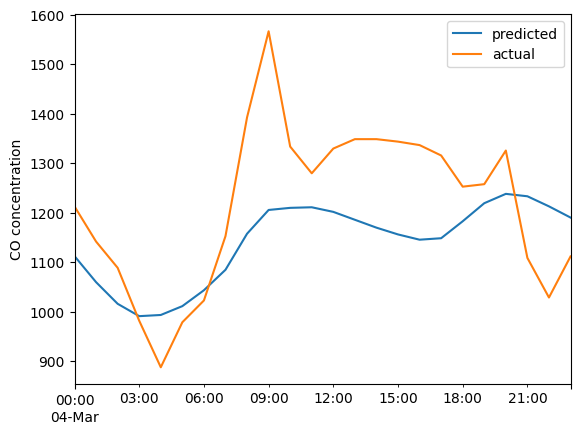

In [40]:
tmp.plot()
plt.ylabel("CO concentration")

Nice!

We now obtained the first 24 hours forecast.